# Trajectory Optimisation

In [1]:
import numpy as np
import torch
from torchdyn.models import NeuralODE

import matplotlib.pyplot as plt
import sys
import time
sys.path.append("../../")

### Set Seed Here

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.manual_seed(0)

### Define the Dynamic
- Then we can replace this with a NN

In [3]:
from nn import MLP

In [291]:
class CartPole(torch.nn.Module):
    def __init__(self):
        super(CartPole, self).__init__()
        self.g = 10.
        self.m = 1.
        self.l = 0.1

        self._policy = MLP([5, 64, 64, 1], activation='tanh')
    
    def forward(self, y):
        f = torch.zeros_like(y)
        f.requires_grad_(False)
        # Get ddth
        x, dx, th, dth = torch.split(y, [1, 1, 1, 1], dim=1)
        gravity = 9.8
        masscart = 1.0
        masspole = 0.1
        total_mass = (masspole + masscart)
        length = 0.5  # actually half the pole's length
        polemass_length = (masspole * length)
        
        cos = torch.cos(th)
        sin = torch.sin(th)

        actions = self.policy(torch.tensor([x, cos, sin, dx, dth]))
        force = actions
        

        # For the interested reader:
        # https://coneural.org/florian/papers/05_cart_pole.pdf
        temp = (force + polemass_length * dth ** 2 * sin) / total_mass
        thetaacc = (gravity * sin - cos * temp) / (
                    length * (4.0 / 3.0 - masspole * cos ** 2 / total_mass))
        xacc = temp - polemass_length * thetaacc * cos / total_mass

#         f[:, 0] = dx
#         f[:, 1] = ddx
#         f[:, 2] = dth
#         f[:, 3] = ddth

        f[:, 0] = dx
        f[:, 1] = xacc
        f[:, 2] = dth
        f[:, 3] = thetaacc
        return f
    
    def policy(self, x):
        logit = self._policy(x)
        # action = torch.tanh(action)
        # action = torch.clamp(action, min=-2, max=2)
        # probs = torch.nn.functional.softmax(logit, dim=-1)
        # m = torch.distributions.Categorical(probs)
        # actions = m.sample()
        return logit

In [307]:
class CartPole(torch.nn.Module):
    def __init__(self):
        super(CartPole, self).__init__()
        self.g = 10.
        self.m = 1.
        self.l = 0.1

        self._policy = MLP([5, 64, 64, 1], activation='tanh')
    
    def forward(self, y):
        f = torch.zeros_like(y)
        f.requires_grad_(False)
        x, cos, sin, dx, dth = torch.split(y, [1, 1, 1, 1, 1], dim=1)

        gravity = 9.80665
        masscart = 1.0
        masspole = 0.1
        total_mass = (masspole + masscart)
        length = 0.5
        polemass_length = (masspole * length)
        
        u = 0

        temp = (u + polemass_length * dth ** 2 * sin) / total_mass
        ddth = (gravity * sin - cos * temp) / (length * (4.0 / 3.0 - masspole * cos ** 2 / total_mass))
        ddx = temp - polemass_length * ddth * cos / total_mass

        f[:, [0]] = dx
        f[:, [1]] = -sin * dth
        f[:, [2]] = cos * dth
        f[:, [3]] = ddx
        f[:, [4]] = ddth
        return f
    
    def policy(self, x):
        logit = self._policy(x)
        # action = torch.tanh(action)
        # action = torch.clamp(action, min=-2, max=2)
        # probs = torch.nn.functional.softmax(logit, dim=-1)
        # m = torch.distributions.Categorical(probs)
        # actions = m.sample()
        return logit

In [308]:
cartpole = CartPole()
cartpoleODE = NeuralODE(cartpole, sensitivity='adjoint', solver='rk4').to(device)

In [317]:
# test = torch.tensor([[3, 0.5, -0.5, 5, 3]])
test = torch.tensor([[0., -1., 0., 0., 1.]])

# test = torch.tensor([[0, 0, np.pi, 0]]).float()
test = test.requires_grad_(True)

In [318]:
cartpoleODE.defunc(0, test)

tensor([[ 0., -0., -1.,  0.,  0.]], grad_fn=<CopySlices>)

In [319]:
t_span = torch.linspace(0, 0.05, 2)
cartpoleODE.trajectory(test, t_span)[-1, 0, :]

tensor([-1.5945e-05, -9.9877e-01, -4.9649e-02, -9.5273e-04,  9.8025e-01],
       grad_fn=<SliceBackward>)

In [320]:
next_cos = torch.cos(cartpoleODE.trajectory(test, t_span)[-1, 0, :][2])
dcos = torch.autograd.grad(next_cos, test, create_graph=True, allow_unused=True)
dcos

(tensor([[ 0.0000,  0.0024,  0.0486,  0.0000, -0.0025]], grad_fn=<AddBackward0>),)

In [336]:
dummy_func = lambda dum: cartpoleODE.trajectory(dum, t_span)[-1, :, :-1].reshape(1, -1).sum(0)
J = torch.autograd.functional.jacobian(dummy_func, test).permute(1, 0, 2)[0, ...]
J

tensor([[ 1.0000e+00,  3.3203e-05,  9.5272e-04,  5.0000e-02, -1.7936e-05],
        [ 0.0000e+00,  9.9879e-01, -4.8670e-02,  0.0000e+00,  2.4659e-03],
        [ 0.0000e+00,  4.9270e-02,  9.7904e-01,  0.0000e+00, -4.9605e-02],
        [ 0.0000e+00,  1.9801e-03,  3.7903e-02,  1.0000e+00, -1.0701e-03]])

In [335]:
dummy_func = lambda dum: (0.05 * cartpoleODE.defunc(0, dum)[0, :] + dum[0, :])
J = torch.autograd.functional.jacobian(dummy_func, test).permute(1, 0, 2)[0, ...]
J

tensor([[ 1.0000,  0.0000,  0.0000,  0.0500,  0.0000],
        [ 0.0000,  1.0000, -0.0500,  0.0000,  0.0000],
        [ 0.0000,  0.0500,  1.0000,  0.0000, -0.0500],
        [ 0.0000,  0.0000,  0.0383,  1.0000,  0.0000],
        [ 0.0000,  0.0000,  0.7930,  0.0000,  1.0000]])

### Check the Model

In [7]:
init_state = torch.tensor([0, 0, 3 * np.pi / 4, 0]).reshape(1, -1).float()
dt = 0.02
steps = 200
t_span = torch.linspace(0, dt*(steps-1), steps)
traj = cartpoleODE.trajectory(init_state, t_span)
dummy = torch.cat([torch.cos(traj[:, 0, 0:1]), torch.sin(traj[:, 0, 0:1]), traj[:, 0, 1:]], dim=1)
actions = cartpoleODE.defunc.m.policy(dummy)
print(traj.shape)
print(actions.shape)

torch.Size([200, 1, 4])
torch.Size([200, 1])


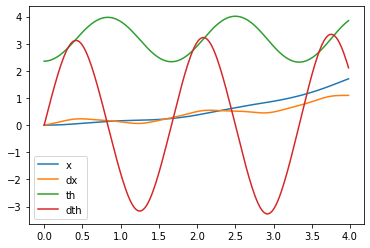

In [8]:
plt.plot(t_span.detach().numpy(), traj[:, 0, 0:4].detach().numpy())
plt.legend(['x', 'dx', 'th', 'dth'])
# plt.plot(t_span.detach().numpy(), actions.detach().numpy())
# plt.ylim(-2, 2)

### Optimise the control

In [9]:
import torch.optim as optim

In [10]:
optimizer = optim.Adam(cartpole.parameters(), lr=0.05)

In [11]:
traj.shape

torch.Size([200, 1, 4])

In [12]:
def total_cost(traj, actions):
    rc = 10 * torch.square(traj[:, 0, 2]) + 0.1 * torch.square(traj[:, 0, 0]) # + torch.square(traj[:, 0, 3])
    costs = rc
    
    return costs.sum()

0 tensor(57312.2734, grad_fn=<SumBackward0>)


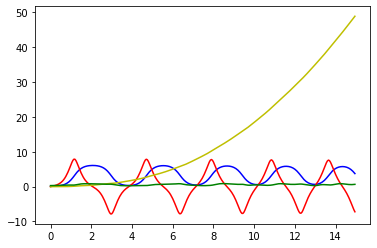

1 tensor(30822.1016, grad_fn=<SumBackward0>)


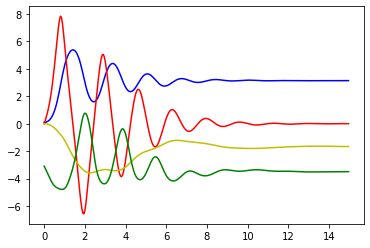

2 tensor(30186.6660, grad_fn=<SumBackward0>)


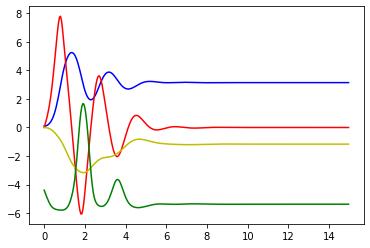

3 tensor(29789.3887, grad_fn=<SumBackward0>)


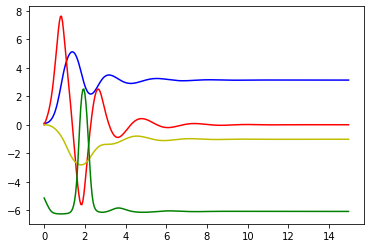

4 tensor(29310.0996, grad_fn=<SumBackward0>)


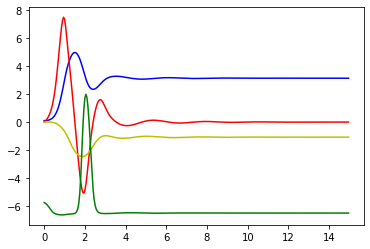

5 tensor(28372.1055, grad_fn=<SumBackward0>)


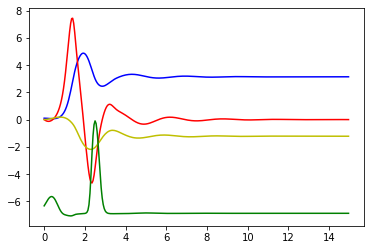

6 tensor(27987.2773, grad_fn=<SumBackward0>)


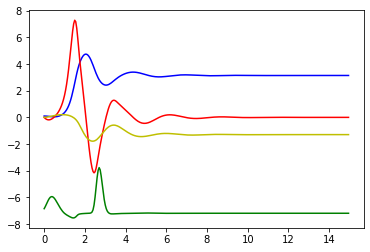

7 tensor(28973.5312, grad_fn=<SumBackward0>)


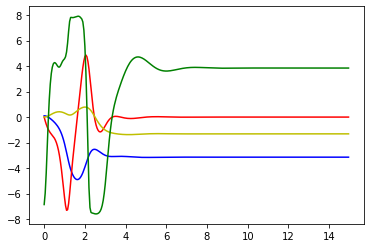

8 tensor(28577.5391, grad_fn=<SumBackward0>)


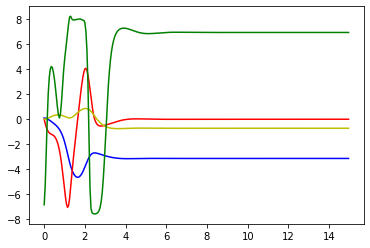

9 tensor(28454.2227, grad_fn=<SumBackward0>)


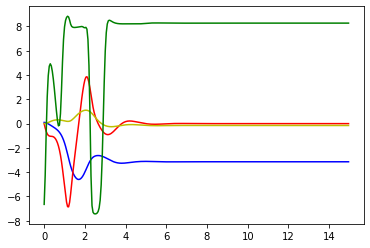

10 tensor(28608.6973, grad_fn=<SumBackward0>)


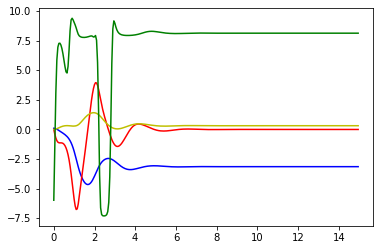

11 tensor(28906.0820, grad_fn=<SumBackward0>)


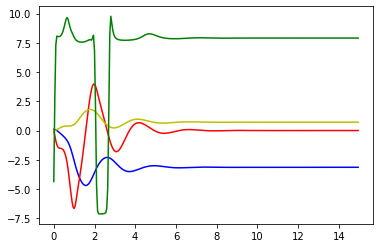

12 tensor(29192.7949, grad_fn=<SumBackward0>)


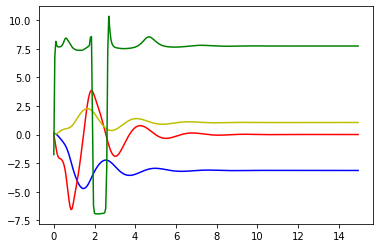

13 tensor(29381.8105, grad_fn=<SumBackward0>)


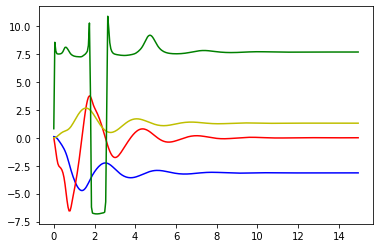

14 tensor(29400.6875, grad_fn=<SumBackward0>)


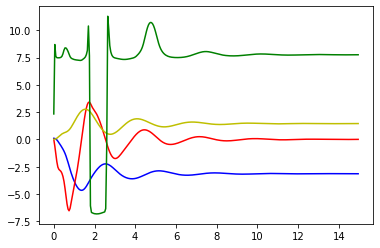

15 tensor(29262.6602, grad_fn=<SumBackward0>)


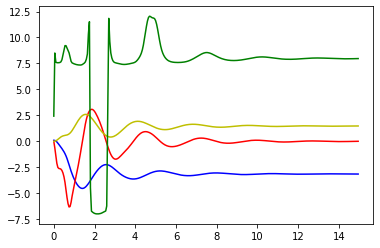

16 tensor(29023.3438, grad_fn=<SumBackward0>)


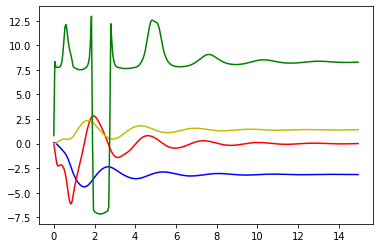

17 tensor(28755.9492, grad_fn=<SumBackward0>)


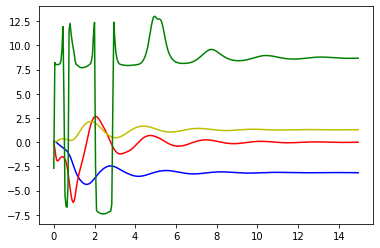

18 tensor(28476.2070, grad_fn=<SumBackward0>)


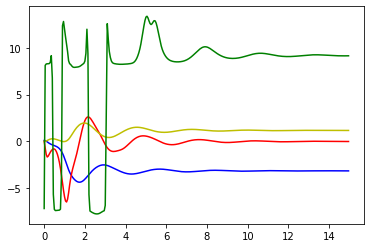

19 tensor(28162.7480, grad_fn=<SumBackward0>)


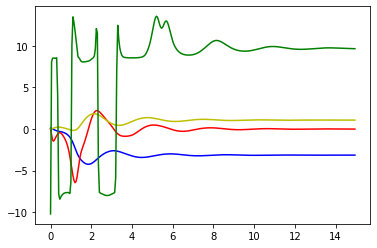

20 tensor(27933.9824, grad_fn=<SumBackward0>)


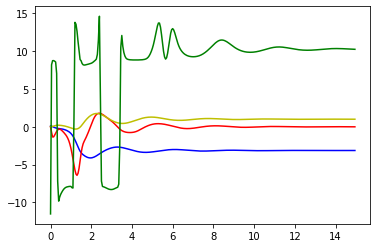

21 tensor(27829.3145, grad_fn=<SumBackward0>)


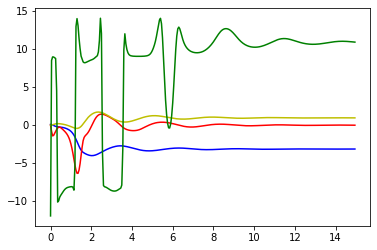

22 tensor(27813.3203, grad_fn=<SumBackward0>)


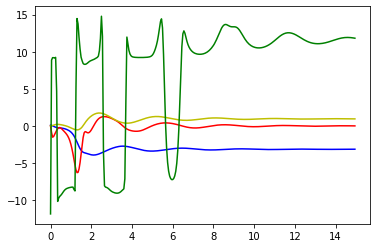

23 tensor(27842.7227, grad_fn=<SumBackward0>)


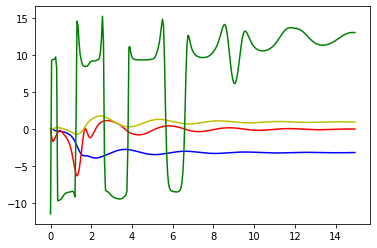

24 tensor(27905.2227, grad_fn=<SumBackward0>)


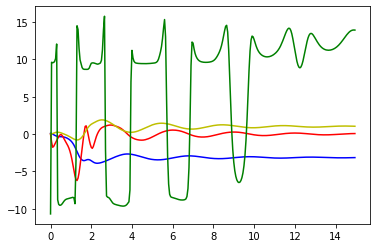

25 tensor(28070.4570, grad_fn=<SumBackward0>)


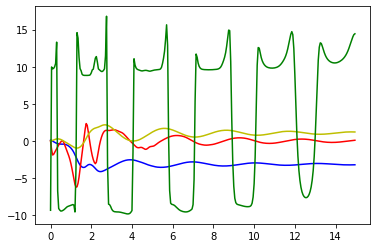

26 tensor(28856.3711, grad_fn=<SumBackward0>)


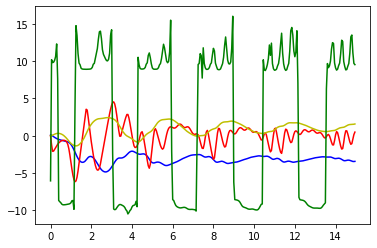

27 tensor(28324.9062, grad_fn=<SumBackward0>)


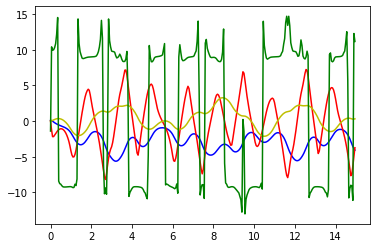

28 tensor(105121.9766, grad_fn=<SumBackward0>)


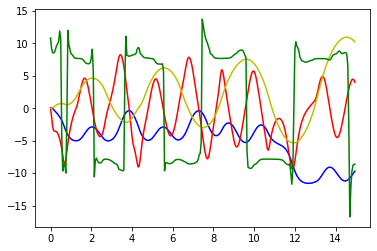

29 tensor(29116.1953, grad_fn=<SumBackward0>)


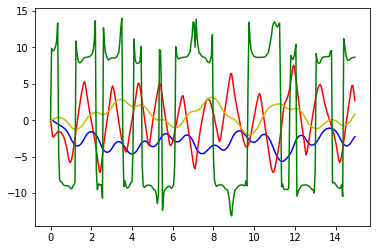

30 tensor(29435.8594, grad_fn=<SumBackward0>)


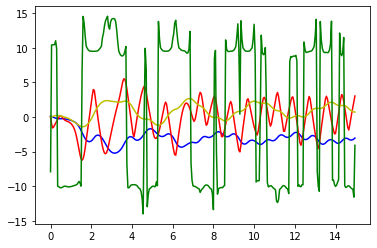

31 tensor(27669.0645, grad_fn=<SumBackward0>)


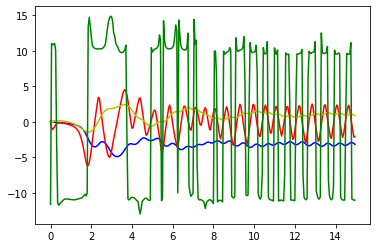

32 tensor(26191.1641, grad_fn=<SumBackward0>)


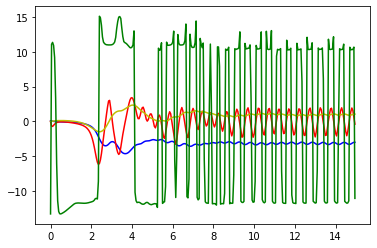

33 tensor(25438.4141, grad_fn=<SumBackward0>)


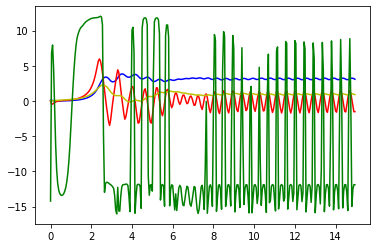

34 tensor(26311.9531, grad_fn=<SumBackward0>)


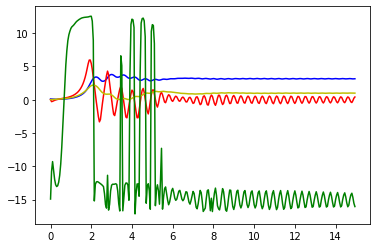

35 tensor(26657.1094, grad_fn=<SumBackward0>)


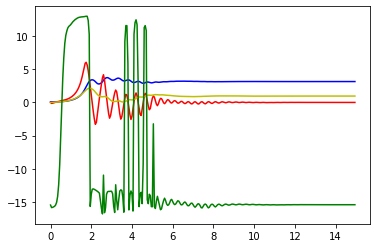

36 tensor(26860.2109, grad_fn=<SumBackward0>)


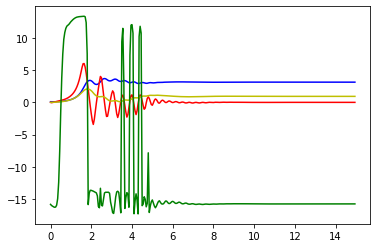

37 tensor(26999.0156, grad_fn=<SumBackward0>)


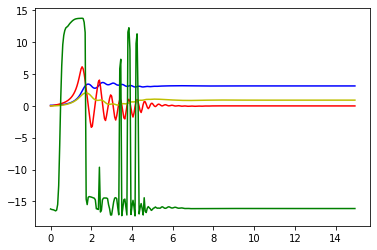

38 tensor(27102.3496, grad_fn=<SumBackward0>)


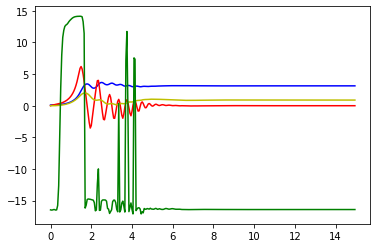

39 tensor(27188.5664, grad_fn=<SumBackward0>)


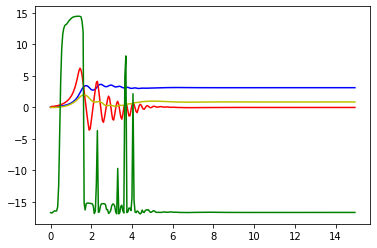

40 tensor(27262.7207, grad_fn=<SumBackward0>)


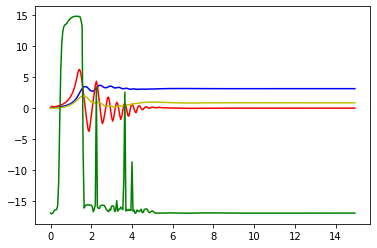

41 tensor(27318.1133, grad_fn=<SumBackward0>)


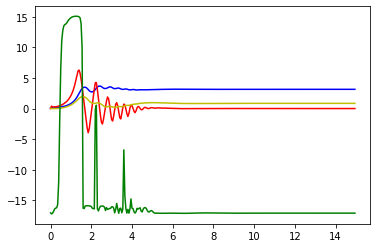

42 tensor(27364.0020, grad_fn=<SumBackward0>)


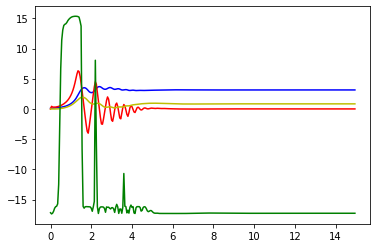

43 tensor(27401.7832, grad_fn=<SumBackward0>)


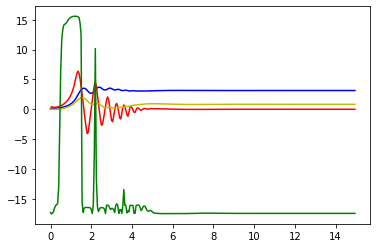

44 tensor(27435.0195, grad_fn=<SumBackward0>)


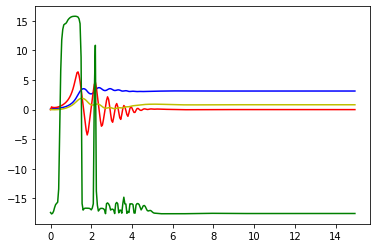

45 tensor(27465.7969, grad_fn=<SumBackward0>)


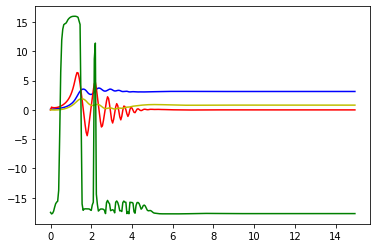

46 tensor(27493.5469, grad_fn=<SumBackward0>)


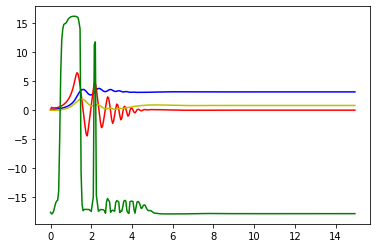

47 tensor(27518.4785, grad_fn=<SumBackward0>)


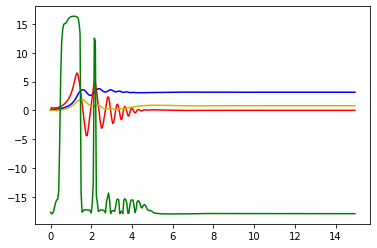

48 tensor(27540.5547, grad_fn=<SumBackward0>)


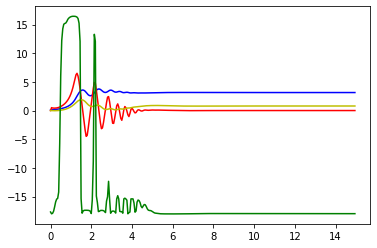

49 tensor(27560.9043, grad_fn=<SumBackward0>)


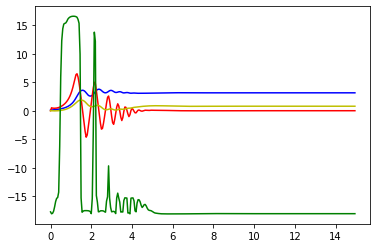

50 tensor(27579.7969, grad_fn=<SumBackward0>)


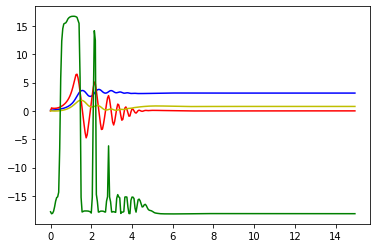

51 tensor(27597.4863, grad_fn=<SumBackward0>)


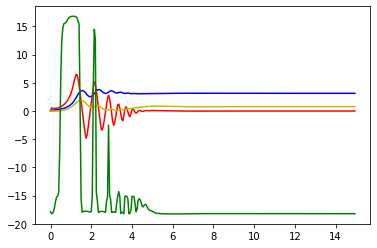

52 tensor(27614.0898, grad_fn=<SumBackward0>)


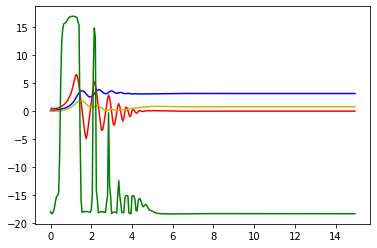

53 tensor(27629.4648, grad_fn=<SumBackward0>)


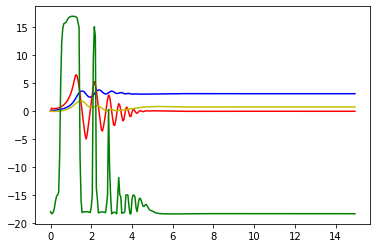

54 tensor(27643.4551, grad_fn=<SumBackward0>)


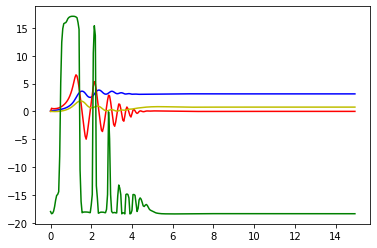

55 tensor(27656.1387, grad_fn=<SumBackward0>)


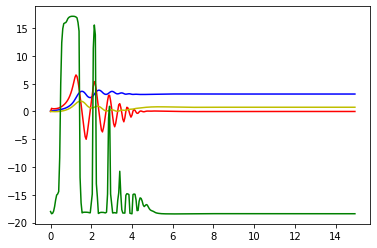

56 tensor(27667.7109, grad_fn=<SumBackward0>)


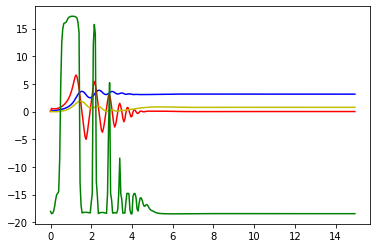

57 tensor(27678.3184, grad_fn=<SumBackward0>)


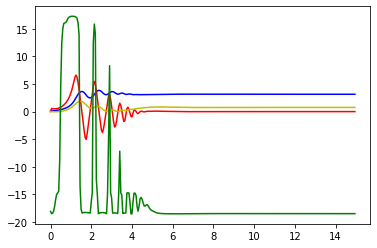

58 tensor(27688.1602, grad_fn=<SumBackward0>)


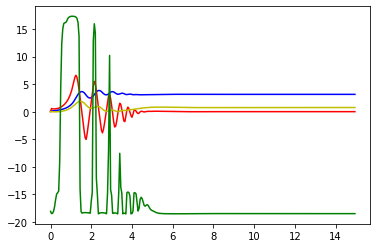

59 tensor(27697.2520, grad_fn=<SumBackward0>)


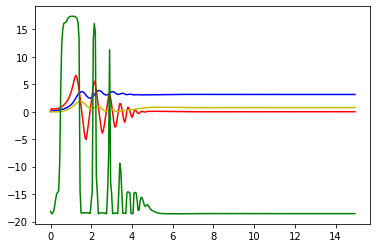

60 tensor(27705.6113, grad_fn=<SumBackward0>)


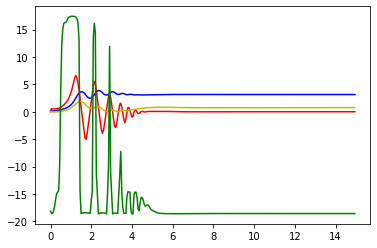

61 tensor(27713.2852, grad_fn=<SumBackward0>)


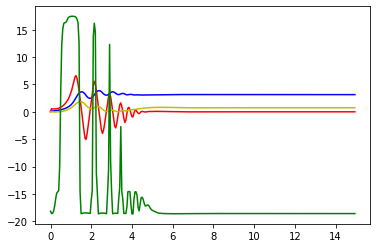

62 tensor(27720.3398, grad_fn=<SumBackward0>)


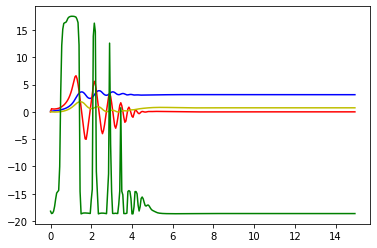

63 tensor(27726.7988, grad_fn=<SumBackward0>)


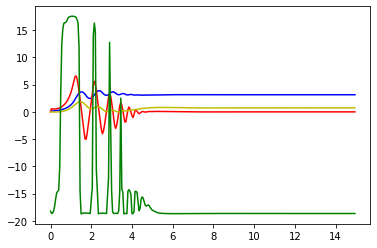

64 tensor(27732.6992, grad_fn=<SumBackward0>)


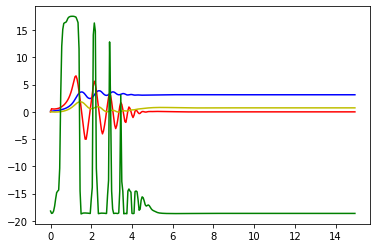

65 tensor(27738.1113, grad_fn=<SumBackward0>)


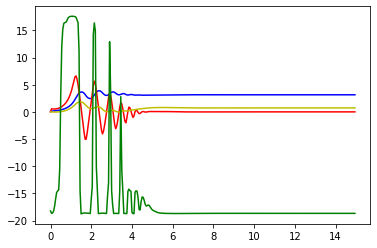

66 tensor(27743.0859, grad_fn=<SumBackward0>)


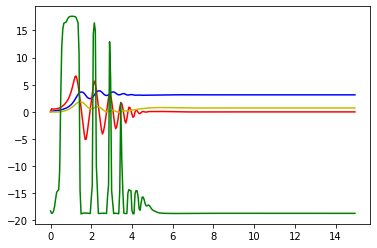

67 tensor(27747.6758, grad_fn=<SumBackward0>)


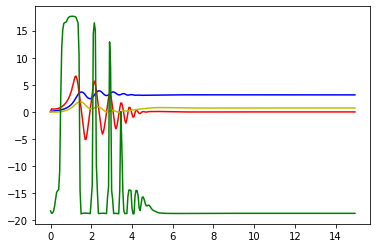

68 tensor(27751.8945, grad_fn=<SumBackward0>)


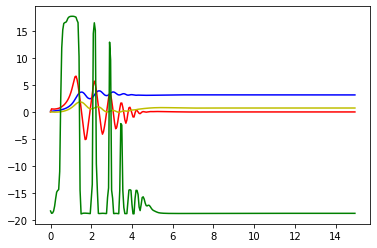

KeyboardInterrupt: 

In [13]:
init_state = torch.tensor([0, 0, 0.1, 0]).reshape(1, -1).float()
dt = 0.05
steps = 300
num_epoch = 10000

target = torch.cat([torch.ones(steps, 1) * np.pi, torch.ones(steps, 1) * -np.pi], dim=1)

for epoch in range(num_epoch):
    optimizer.zero_grad()
    
    # Generate Trajectory
    # init_states = torch.cat([(torch.rand(127, 2) - 0.5) * 4, init_state], dim=0)
    # init_state[:, 2] = torch.rand(1).view(1, -1).float() * 0.5
    t_span = torch.linspace(0, dt * (steps-1), steps)
    
    traj = cartpoleODE.trajectory(init_state, t_span)
    dummy = torch.cat([torch.cos(traj[:, 0, 0:1]), torch.sin(traj[:, 0, 0:1]), traj[:, 0, 1:]], dim=1)
    actions = cartpoleODE.defunc.m.policy(dummy)
    
    loss = total_cost(traj, actions)
    loss.backward()
    optimizer.step()

    # print statistics
    if epoch % 1 == 0:
        print(epoch, loss)
        plt.plot(t_span.detach().numpy(), traj[:, 0, 2].detach().numpy(), 'b-')  # theta
        plt.plot(t_span.detach().numpy(), traj[:, 0, 3].detach().numpy(), 'r-')  # theta_dot
        plt.plot(t_span.detach().numpy(), traj[:, 0, 0].detach().numpy(), 'y-')  # x-pos
        plt.plot(t_span.detach().numpy(), actions.detach().numpy(), 'g-')
#         plt.ylim(-7, 7)
        plt.show()
print('Finished Training')

In [ ]:
torch.rand(1).view(1, -1).float().shape

In [ ]:
pendulumODE.eval()
None

In [ ]:
init_state = torch.tensor([0, 0]).reshape(1, -1).float()
t_span = torch.linspace(0, 5, 100)
traj = pendulumODE.trajectory(init_state, t_span)
# dummy = torch.stack([torch.cos(traj[:, 0, 0]), torch.sin(traj[:, 0, 0]), traj[:, 0, 1]], dim=1)
# actions = pendulumODE.defunc.m.policy(dummy)
actions = pendulumODE.defunc.m.policy(traj)
print(traj.shape)
print(actions.shape)

In [ ]:
plt.plot(t_span.detach().numpy(), traj[:, 0, 0:2].detach().numpy())
plt.plot(t_span.detach().numpy(), actions.detach().numpy())

## Conclusion